# Language Clustering Across Philippine Provinces

This is a supplementary notebook that analyzes the distribution and relationships between different languages spoken across various provinces in the Philippines. The analysis includes:

1. Language distribution mapping
2. Provincial linguistic diversity analysis
3. Language similarity computation
4. Province-to-province linguistic relationships
5. Hierarchical clustering of provinces based on language similarity

## Data Sources
- Language distribution data by province
- Character-based language similarity matrix
- Word-based language similarity matrix

Tagalog
Cebuano
Chavacano -> Zambageño-Chavacano
Kapampangan
Bikolano -> Bikol/Bicol
Isnag -> Isneg/Isnag/Apayao
Tausug
Kalinga
Sambal x
Ilokano Ilocano
Kankanaey
Yakan
Yami x
Spanish x
Ivatan
Pangasinense -> Pangasinan/Panggalato

In [1]:
import pandas as pd

## Data Loading and Preprocessing

This section loads the necessary data and performs initial preprocessing.

In [2]:
data_map_df = pd.read_csv(
    "../data/language_map/data_map.csv",
    sep="\t",
    na_values=["NA", ""],
    encoding="utf-16",
    engine="python",
)

In [3]:
data_map_df.head()

,Country,Primary language generally spoken at home,Province,2Nd Most Spoken Language At Home,3Rd Most Spoken Language At Home,Data source link,Data source release date,Data source,Primary language generally spoken at home2,Latitude (generated),...,2Nd Most Spoken Language At Home (% Of Households),3Rd Most Spoken Language At Home (# Of Households),3Rd Most Spoken Language At Home (% Of Households),Female literacy rate (10 years and over),Literacy rate (10 years and over),Male literacy rate (Males 10 years and over),Primary language generally spoken at home (# of households),Primary language generally spoken at home (% of households),Total number of households,Total population
0,Philippines,Yakan,Basilan,Tausug,Zambageño-Chavacano,https://psa.gov.ph/tags/2010-census-population...,7/31/2014,2010 Census of Population and Housing - Philip...,Yakan,6.5790,...,0.211301,3840,0.074488,0.792255,0.800570,0.809059,26854,0.520911,51552,293204
1,Philippines,Waray,Samar,Bisaya/Binisaya,Cebuano,https://psa.gov.ph/tags/2010-census-population...,7/31/2014,2010 Census of Population and Housing - Philip...,Waray,11.7112,...,0.036679,3820,0.026179,0.956019,0.941151,0.927246,135741,0.930268,145916,731669
2,Philippines,Waray,Northern Samar,Cebuano,Other Local Dialects,https://psa.gov.ph/tags/2010-census-population...,7/31/2014,2010 Census of Population and Housing - Philip...,Waray,12.3912,...,0.026136,2410,0.021144,0.964095,0.954692,0.945699,106353,0.933085,113980,587586
3,Philippines,Waray,Leyte,Bisaya/Binisaya,Cebuano,https://psa.gov.ph/tags/2010-census-population...,7/31/2014,2010 Census of Population and Housing - Philip...,Waray,10.8742,...,0.446450,22886,0.058409,0.977121,0.971407,0.965941,191494,0.488725,391824,1782678
4,Philippines,Waray,Eastern Samar,Cebuano,Tagalog,https://psa.gov.ph/tags/2010-census-population...,7/31/2014,2010 Census of Population and Housing - Philip...,Waray,11.6937,...,0.003298,294,0.003265,0.976760,0.969308,0.962377,89182,0.990460,90041,427974


In [4]:
print(data_map_df.columns)

Index(['Country', 'Primary language generally spoken at home', 'Province',
       '2Nd Most Spoken Language At Home', '3Rd Most Spoken Language At Home',
       'Data source link', 'Data source release date', 'Data source',
       'Primary language generally spoken at home2', 'Latitude (generated)',
       'Longitude (generated)', '# Of Languages Reported',
       '2Nd Most Spoken Language At Home (# Of Households)',
       '2Nd Most Spoken Language At Home (% Of Households)',
       '3Rd Most Spoken Language At Home (# Of Households)',
       '3Rd Most Spoken Language At Home (% Of Households)',
       'Female literacy rate (10 years and over)',
       'Literacy rate (10 years and over)',
       'Male literacy rate (Males 10 years and over)',
       'Primary language generally spoken at home (# of households)',
       'Primary language generally spoken at home (% of households)',
       'Total number of households', 'Total population'],
      dtype='object')


In [5]:
lang_map = {
    "Zambageño-Chavacano": "Chavacano",
    "Bikol/Bicol": "Bikolano",
    "Isneg/Isnag/Apayao": "Isnag",
    "Pangasinan/Panggalato": "Pangasinense",
}

cols = [
    "Primary language generally spoken at home",
    "2Nd Most Spoken Language At Home",
    "3Rd Most Spoken Language At Home",
]

data_map_df[cols] = data_map_df[cols].replace(lang_map)

print(data_map_df[cols].tail())

   Primary language generally spoken at home 2Nd Most Spoken Language At Home  \
78                                  Bikolano                          Tagalog   
79                                  Bikolano                          Tagalog   
80                                  Bikolano                          Tagalog   
81                                  Bikolano                          Tagalog   
82                                   Akeanon                          Tagalog   

   3Rd Most Spoken Language At Home  
78                  Bisaya/Binisaya  
79                 American/English  
80             Other Local Dialects  
81                  Bisaya/Binisaya  
82               Hiligaynon Ilonggo  


In [6]:
# combine all language columns into a single long-form column for counting
lang_cols = [
    "Primary language generally spoken at home",
    "2Nd Most Spoken Language At Home",
    "3Rd Most Spoken Language At Home",
]

# melt into long format: each row = one (province, language, rank)
lang_long = data_map_df.melt(
    id_vars=["Province"],
    value_vars=lang_cols,
    var_name="Language_Rank",
    value_name="Language",
)

# count number of provinces where each language appears
language_counts = (
    lang_long.groupby("Language")["Province"].nunique().sort_values(ascending=False)
)

print("Number of provinces where each language is spoken:")
display(language_counts.head(20))

Number of provinces where each language is spoken:


Language
Bisaya/Binisaya            45
Tagalog                    39
Cebuano                    31
Ilocano                    22
Hiligaynon Ilonggo         13
Bikolano                   11
Other Local Dialects        5
Waray                       5
Kankanaey                   4
Kapampangan                 4
Karay-a                     4
Maguindanao                 4
Tausug                      4
Chavacano                   3
Surigaonon                  3
Manobo                      2
Subanen/Subanon/Subanun     2
Isnag                       2
Ibanag                      2
Boholano                    2
Name: Province, dtype: int64

## Language Distribution Analysis

This section analyzes the distribution of languages across provinces.

In [7]:
multilingual_provinces = data_map_df[
    ["Province", "# Of Languages Reported"]
].sort_values("# Of Languages Reported", ascending=False)

print("Provinces with highest linguistic diversity:")
display(multilingual_provinces.head(20))

Provinces with highest linguistic diversity:


,Province,# Of Languages Reported
15,National Capital Region,121
70,Davao del Sur,86
18,Cavite,83
53,Cotabato,82
11,Palawan,81
74,Bukidnon,77
49,South Cotabato,76
59,Zamboanga del Sur,74
41,Isabela,72
71,Davao del Norte,71


In [8]:
data_sim_char_df = pd.read_csv(
    "../data/language_map/data_sim_char.csv", sep=",", index_col=0, na_values=["NA", ""]
)

data_sim_char_df.head()

,Bikolano,Cebuano,Chavacano,Ilokano,Isnag,Ivatan,Kalinga,Kankanaey,Kapampangan,Pangasinense,Sambal,Spanish,Tagalog,Tausug,Yakan,Yami
Bikolano,1.000,0.776,0.306,0.442,0.526,0.608,0.640,0.606,0.579,0.706,0.685,0.202,0.780,0.683,0.515,0.554
Cebuano,0.776,1.000,0.294,0.408,0.485,0.475,0.490,0.418,0.607,0.543,0.506,0.168,0.917,0.544,0.421,0.447
Chavacano,0.306,0.294,1.000,0.259,0.335,0.376,0.309,0.302,0.204,0.373,0.362,0.670,0.275,0.285,0.259,0.331
Ilokano,0.442,0.408,0.259,1.000,0.444,0.504,0.429,0.454,0.346,0.506,0.483,0.202,0.410,0.375,0.307,0.481
Isnag,0.526,0.485,0.335,0.444,1.000,0.493,0.541,0.565,0.396,0.544,0.545,0.168,0.473,0.508,0.346,0.463


## Language Similarity Matrices

Here, we load and examine two types of language similarity matrices:
1. Character-based similarity (`data_sim_char.csv`): Measures similarity based on character-level features
2. Word-based similarity (`data_sim_word.csv`): Measures similarity based on word-level features

These matrices will be used to compute province-to-province linguistic relationships.

In [9]:
data_sim_word_df = pd.read_csv(
    "../data/language_map/data_sim_word.csv", sep=",", index_col=0, na_values=["NA", ""]
)

data_sim_word_df.head()

,Bikolano,Cebuano,Chavacano,Ilokano,Isnag,Ivatan,Kalinga,Kankanaey,Kapampangan,Pangasinense,Sambal,Spanish,Tagalog,Tausug,Yakan,Yami
Bikolano,1.000,0.424,0.107,0.023,0.182,0.215,0.223,0.024,0.175,0.214,0.202,0.012,0.453,0.124,0.063,0.198
Cebuano,0.424,1.000,0.025,0.074,0.140,0.123,0.026,0.015,0.022,0.026,0.026,0.005,0.643,0.023,0.049,0.026
Chavacano,0.107,0.025,1.000,0.020,0.263,0.114,0.140,0.164,0.142,0.180,0.162,0.438,0.080,0.049,0.098,0.135
Ilokano,0.023,0.074,0.020,1.000,0.102,0.365,0.012,0.054,0.161,0.283,0.371,0.176,0.029,0.001,0.001,0.339
Isnag,0.182,0.140,0.263,0.102,1.000,0.163,0.182,0.362,0.258,0.261,0.278,0.056,0.174,0.108,0.046,0.200


Province language profiles extracted successfully.
[('Basilan', [('Yakan', 0.520910925), ('Tausug', 0.21130121), ('Chavacano', 0.074487896)]), ('Samar', [('Waray', 0.930268099), ('Bisaya/Binisaya', 0.036678637), ('Cebuano', 0.026179446)]), ('Northern Samar', [('Waray', 0.933084752), ('Cebuano', 0.026136164), ('Other Local Dialects', 0.02114406)])]
Province-to-province linguistic similarity matrix computed.


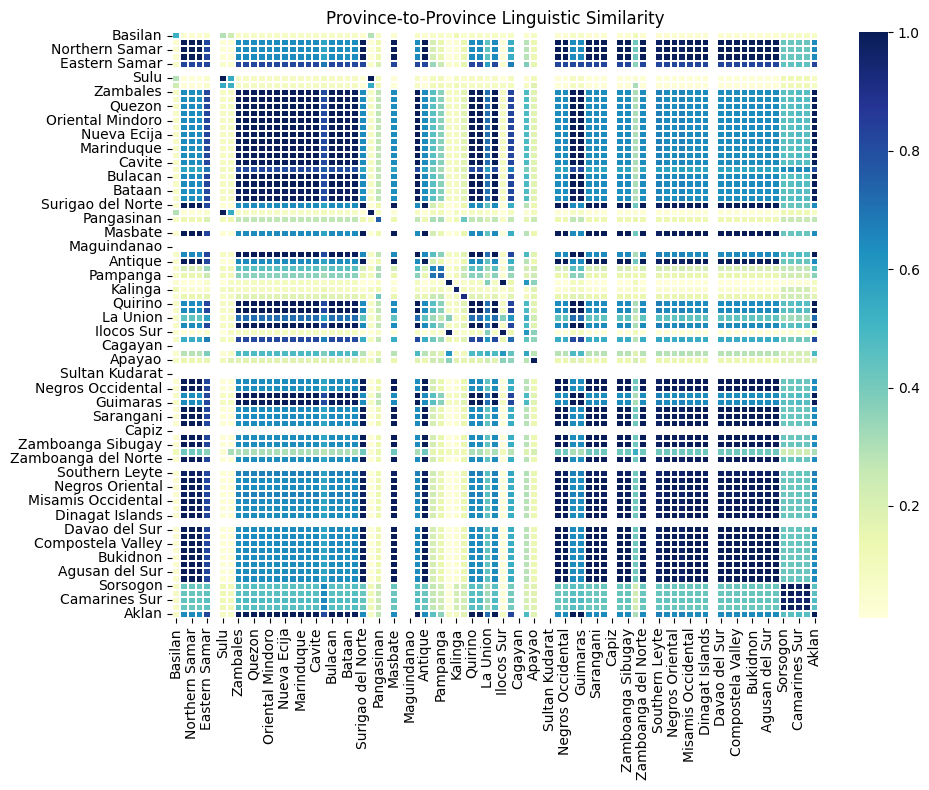

In [10]:
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage

# STEP 1 Build province-level language-weight profiles


def extract_lang_profile(row):
    """Return [(language, weight), ...] for a province."""
    langs = [
        (
            row["Primary language generally spoken at home"],
            row["Primary language generally spoken at home (% of households)"],
        ),
        (
            row["2Nd Most Spoken Language At Home"],
            row["2Nd Most Spoken Language At Home (% Of Households)"],
        ),
        (
            row["3Rd Most Spoken Language At Home"],
            row["3Rd Most Spoken Language At Home (% Of Households)"],
        ),
    ]
    # keep only valid entries
    return [
        (lang, float(weight))
        for lang, weight in langs
        if isinstance(lang, str) and pd.notna(weight)
    ]


province_profiles = {
    row["Province"]: extract_lang_profile(row) for _, row in data_map_df.iterrows()
}

print("Province language profiles extracted successfully.")
print(list(province_profiles.items())[:3])

# STEP 2 Compute province–province weighted linguistic similarity


def province_similarity(profile_a, profile_b, sim_df):
    """Weighted mean of all language-to-language similarities."""
    if not profile_a or not profile_b:
        return np.nan
    num, denom = 0.0, 0.0
    for (langA, wA), (langB, wB) in product(profile_a, profile_b):
        if langA in sim_df.index and langB in sim_df.columns:
            sim = sim_df.loc[langA, langB]
            num += sim * wA * wB
            denom += wA * wB
    return num / denom if denom > 0 else np.nan


provinces = list(province_profiles.keys())
prov_sim_matrix = pd.DataFrame(index=provinces, columns=provinces, dtype=float)

for p1 in provinces:
    for p2 in provinces:
        prov_sim_matrix.loc[p1, p2] = province_similarity(
            province_profiles[p1], province_profiles[p2], data_sim_word_df
        )

print("Province-to-province linguistic similarity matrix computed.")

# STEP 3 Visualize heatmap

plt.figure(figsize=(10, 8))
sns.heatmap(prov_sim_matrix, cmap="YlGnBu", linewidths=0.3)
plt.title("Province-to-Province Linguistic Similarity")
plt.tight_layout()
plt.show()

# save matrix for later use
prov_sim_matrix.to_csv("../data/language_map/province_similarity_matrix.csv")

## Province-Level Language Profile and Similarity Analysis

This section performs the core analysis:
1. Building province-level language profiles with weights
2. Computing province-to-province linguistic similarity using weighted averages
3. Visualizing the similarity matrix as a heatmap
4. Saving the computed similarity matrix for future use

The similarity calculation considers both the presence of languages and their relative usage in each province.

Top-k nearest linguistic neighbors:


,Province,Neighbor,Similarity
0,Basilan,Sulu,0.292287
1,Basilan,Tawi-Tawi,0.292287
2,Basilan,City of Isabela,0.233146
3,Samar,Northern Samar,1.000000
4,Samar,Leyte,1.000000
5,Samar,Compostela Valley,1.000000
6,Northern Samar,Samar,1.000000
7,Northern Samar,Leyte,1.000000
8,Northern Samar,Compostela Valley,1.000000
9,Leyte,Samar,1.000000


Provinces with lowest average linguistic similarity:


Basilan              0.071745
City of Isabela      0.088105
Mountain Province    0.092083
Ilocos Sur           0.092083
Tawi-Tawi            0.092842
dtype: float64

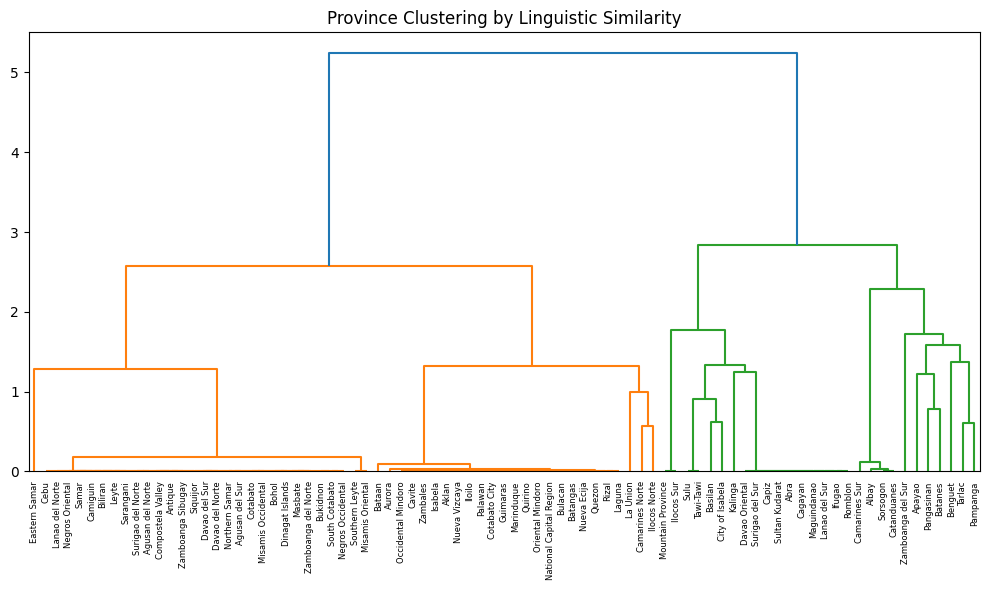

In [11]:
k = 3  # number of top neighbors
neighbors = []

for province in prov_sim_matrix.index:
    sims = prov_sim_matrix.loc[province].drop(province).dropna()
    topk = sims.sort_values(ascending=False).head(k)
    for neighbor, score in topk.items():
        neighbors.append(
            {"Province": province, "Neighbor": neighbor, "Similarity": score}
        )

neighbor_df = pd.DataFrame(neighbors)
print("Top-k nearest linguistic neighbors:")
display(neighbor_df.head(10))

# outliers (most unique provinces)
avg_similarity = prov_sim_matrix.mean(axis=1)
outliers = avg_similarity.sort_values().head(5)
print("Provinces with lowest average linguistic similarity:")
display(outliers)

# clustering view
linkage_matrix = linkage(prov_sim_matrix.fillna(0), method="average")
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, labels=prov_sim_matrix.index, leaf_rotation=90)
plt.title("Province Clustering by Linguistic Similarity")
plt.tight_layout()
plt.show()